In [1]:
import pickle

import pandas as pd
from helpers import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf

/home/vecht499/.local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from sklearn.metrics import confusion_matrix

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == labels) / predictions.shape[0])

## Load dataset

In [3]:
with open('../data/prepared_data.pickle', 'rb') as data:
    data_dic = pickle.load(data)

In [4]:
train = data_dic['sample_df']['train']
test  = data_dic['sample_df']['test']
valid = data_dic['sample_df']['valid']

In [5]:
train_dataset = np.array(train.sentence_vecs.tolist())
test_dataset  = np.array(test.sentence_vecs.tolist())
valid_dataset = np.array(valid.sentence_vecs.tolist())

In [6]:
train_labels = np.array(train.cat2_num.tolist())
test_labels  = np.array(test.cat2_num.tolist())
valid_labels = np.array(valid.cat2_num.tolist())

In [7]:
vocab_len = data_dic['sample_df']['vocab_len']

## Ready for tensorflow!

In [8]:
SEQ_LENGTH = 100
BATCH_SIZE = 50
NUM_LABELS = 64

VOCAB_SIZE = vocab_len
EMBED_SIZE = 128

FILTER_SIZE_1 = 3
FILTER_SIZE_2 = 4
FILTER_SIZE_3 = 5
NUM_FILTERS = 128

keep_prob = 0.8
l2_reg_lambda=0.0


tf_train_dataset = tf.placeholder(tf.int32, shape=(BATCH_SIZE, SEQ_LENGTH), name="input_x")
tf_train_labels = tf.placeholder(tf.int32, shape=(BATCH_SIZE), name="input_y")
tf_valid_dataset = tf.constant(valid_dataset) 
tf_test_dataset = tf.constant(test_dataset)

# Keeping track of l2 regularization loss (optional)
l2_loss = tf.constant(0.0)

## Embedding layer

embed_weigths = tf.Variable(tf.random_uniform([VOCAB_SIZE, EMBED_SIZE], -1.0, 1.0))
    
## Convolutional layers
## Change to True if run again
with tf.variable_scope("vars", reuse = None):
    
    conv1_weights = tf.get_variable("conv1_w", shape=[FILTER_SIZE_1, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv1_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv1_b")

    conv2_weights = tf.get_variable("conv2_w", shape=[FILTER_SIZE_2, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv2_b")

    conv3_weights = tf.get_variable("conv3_w", shape=[FILTER_SIZE_3, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv3_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv3_b")

## Fully connected layer

    fc1_weights = tf.get_variable("fc1_w", shape=[3*NUM_FILTERS, NUM_LABELS],\
                                                initializer=tf.contrib.layers.xavier_initializer())
    fc1_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]), name = "fc1_b")

# Model:
def model(data, keep_prob = keep_prob): 
    
    ## Embedding layer
    ## input shape:[BATCH_SIZE, SEQ_LENGTH]
    ## output shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    
    with tf.device('/cpu:0'), tf.name_scope("word2vec_embedding"):    
        embed_chars = tf.nn.embedding_lookup(embed_weigths, data)
        embed_chars = tf.expand_dims(embed_chars, -1)
    
    ## Conv1+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("conv1-maxpool-3"):
        conv1 = tf.nn.conv2d(embed_chars, conv1_weights, strides=[1, 1, 1, 1], padding="VALID")
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
        pool1 = tf.nn.max_pool(relu1, ksize=[1, SEQ_LENGTH-FILTER_SIZE_1+1, 1, 1],
                               strides=[1, 1, 1, 1], padding='VALID')
    ## Conv2+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("conv2-maxpool-4"):
        conv2 = tf.nn.conv2d(embed_chars, conv2_weights, strides=[1, 1, 1, 1], padding="VALID")
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
        pool2 = tf.nn.max_pool(relu2, ksize=[1, SEQ_LENGTH-FILTER_SIZE_2+1, 1, 1],
                               strides=[1, 1, 1, 1], padding='VALID')
    
    ## Conv3+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("conv3-maxpool-5"):
        conv3 = tf.nn.conv2d(embed_chars, conv3_weights, strides=[1, 1, 1, 1], padding="VALID")
        relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_biases))
        pool3 = tf.nn.max_pool(relu3, ksize=[1, SEQ_LENGTH-FILTER_SIZE_3+1, 1, 1],
                               strides=[1, 1, 1, 1], padding='VALID')
    
    ## Combine pooled features + flatten
    ## input shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    ## output shape: [BATCH_SIZE, 3, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("combine_flatten"):
        pooled_outputs = [pool1, pool2, pool3]
        h_pool = tf.concat(pooled_outputs,3)
        h_pool_flat = tf.reshape(h_pool, [-1, NUM_FILTERS*3])
    
    with tf.name_scope("dropout"):
        h_pool_flat = tf.nn.dropout(h_pool_flat, keep_prob)
    
    ## Fully connected layer
    with tf.name_scope("output"):
        return tf.matmul(h_pool_flat, fc1_weights) + fc1_biases  
  
#Training computation:
logits = model(tf_train_dataset)
with tf.name_scope("loss"):
    l2_loss += tf.nn.l2_loss(fc1_weights)
    l2_loss += tf.nn.l2_loss(fc1_biases)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) 
    + l2_reg_lambda * l2_loss
  
# Optimizer:
optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

#saver = tf.train.Saver()

**Predictions for the training, validation, and test data**

In [9]:
train_prediction = tf.nn.softmax(logits)
valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
test_prediction = tf.nn.softmax(model(tf_test_dataset))

## Train model and report accuracy

In [10]:
NUM_ITERATIONS = 1001

step = []
pred = []
loss_minibatch = []
accuracy_minibatch = []
accuracy_valid = []

logs_path = '../tensorflow_logs/example_category2_simple'

with tf.Session() as session:
    tf.global_variables_initializer().run()
    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    for i in range(NUM_ITERATIONS):
        offset = (i * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict) 
        
        if (i % 200 == 0): ## info will be printed every 1000th time
            step.append(i)
            print("Minibatch loss at step %d: %f" % (i, l))
            loss_minibatch.append(l)
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            accuracy_minibatch.append(accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))    
            accuracy_valid.append(accuracy(valid_prediction.eval(), valid_labels))
           
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    
    #save_path = saver.save(session, "../models/cat2_cnn_simple.ckpt")
    #print("Model saved in file: %s" % save_path)
    
    pred.append(np.argmax(test_prediction.eval(), 1))
    
    print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs " \
          "\nThen open http://172.26.179.29:6006/ into your web browser")

pred = pred[0]

Minibatch loss at step 0: 4.231567
Minibatch accuracy: 0.0%
Validation accuracy: 2.1%
Minibatch loss at step 200: 3.697731
Minibatch accuracy: 12.0%
Validation accuracy: 7.3%
Minibatch loss at step 400: 3.784536
Minibatch accuracy: 8.0%
Validation accuracy: 9.5%
Minibatch loss at step 600: 3.670457
Minibatch accuracy: 14.0%
Validation accuracy: 14.2%
Minibatch loss at step 800: 3.352957
Minibatch accuracy: 24.0%
Validation accuracy: 16.3%
Minibatch loss at step 1000: 3.182070
Minibatch accuracy: 18.0%
Validation accuracy: 18.0%

Test accuracy: 17.5%
Run the command line:
--> tensorboard --logdir=/tmp/tensorflow_logs 
Then open http://172.26.179.29:6006/ into your web browser


In [20]:
train[["cat2_num","cat2"]].drop_duplicates().sort_values(by="cat2_num")

,cat2_num,cat2
66617,0,action toy figures
87715,1,arts crafts
35767,2,baby child care
70837,3,baby toddler toys
176870,4,baby food
178987,5,bath body
148397,6,bathing skin care
112721,7,beverages
58933,8,birds
59326,9,breads bakery


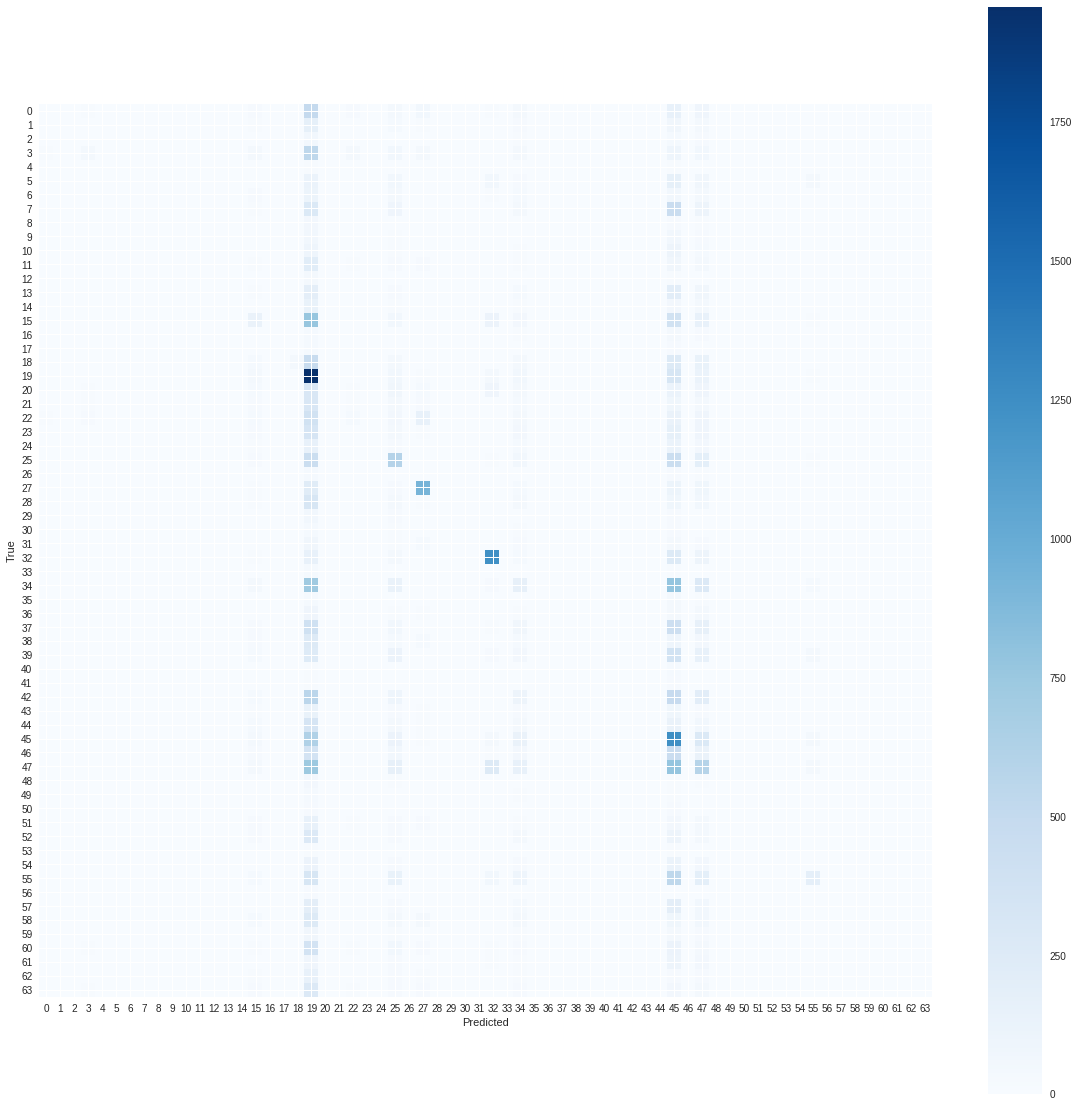

In [17]:
cm = confusion_matrix(test_labels, pred)
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(64))
plt.yticks(range(64))
plt.xlabel('Predicted')
plt.ylabel('True')

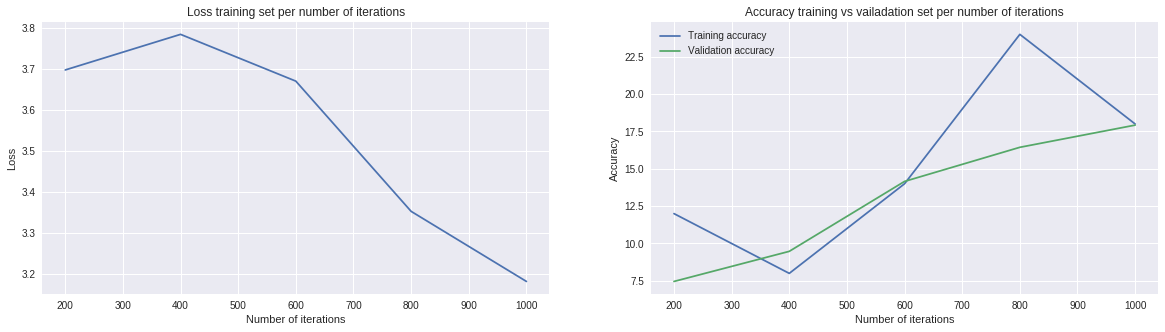

In [18]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(step[1:len(step)],loss_minibatch[1:len(step)])
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.title('Loss training set per number of iterations')

plt.subplot(1, 2, 2)
plt.plot(step[1:len(step)],accuracy_minibatch[1:len(step)], label = 'Training accuracy')
plt.plot(step[1:len(step)],accuracy_valid[1:len(step)], label = 'Validation accuracy')
plt.legend(loc = 0)
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy training vs vailadation set per number of iterations')